# 이미지 필터링

이미지 필터링은 여러 수식을 이용하여 이미지를 이루고 있는 픽셀 행렬을 다른 값으로 바꾸어 이미지를 변형하는 것을 말한다. 

## 임계처리

임계처리(thresholding)는 이미지 행렬에서 하나의 픽셀값을 사용자가 지정한 기준값(threshold)를 사용하여 이진화(binarization)하는 가장 단순한 필터다. OpenCV에서는 `threshold`라는 함수로 구현되어 있다. 인수는 다음과 같다. 

* `threshold(src, thresh, maxval, type)` 
  * `src` : 그레이 스케일 이미지
  * `thresh` : 기준값
  * `maxval` : 기준값을 넘었을 때 적용할 최대값
  * `type` : 임계처리 유형 
    * `THRESH_BINARY` : 기준값을 넘으면 최대값 아니면 0
    * `THRESH_BINARY_INV` : 기준값을 넘으면 0 아니면 최대값
    * `THRESH_TRUNC` : 기준값을 넘으면 기준값 아니면 최대값
    * `THRESH_TOZERO` : 기준값을 넘으면 원래값 아니면 0
    * `THRESH_TOZERO_INV` : 기준값을 넘으면 0 아니면 원래값
  

각 임계유형의 결과를 시각화하면 다음과 같다.

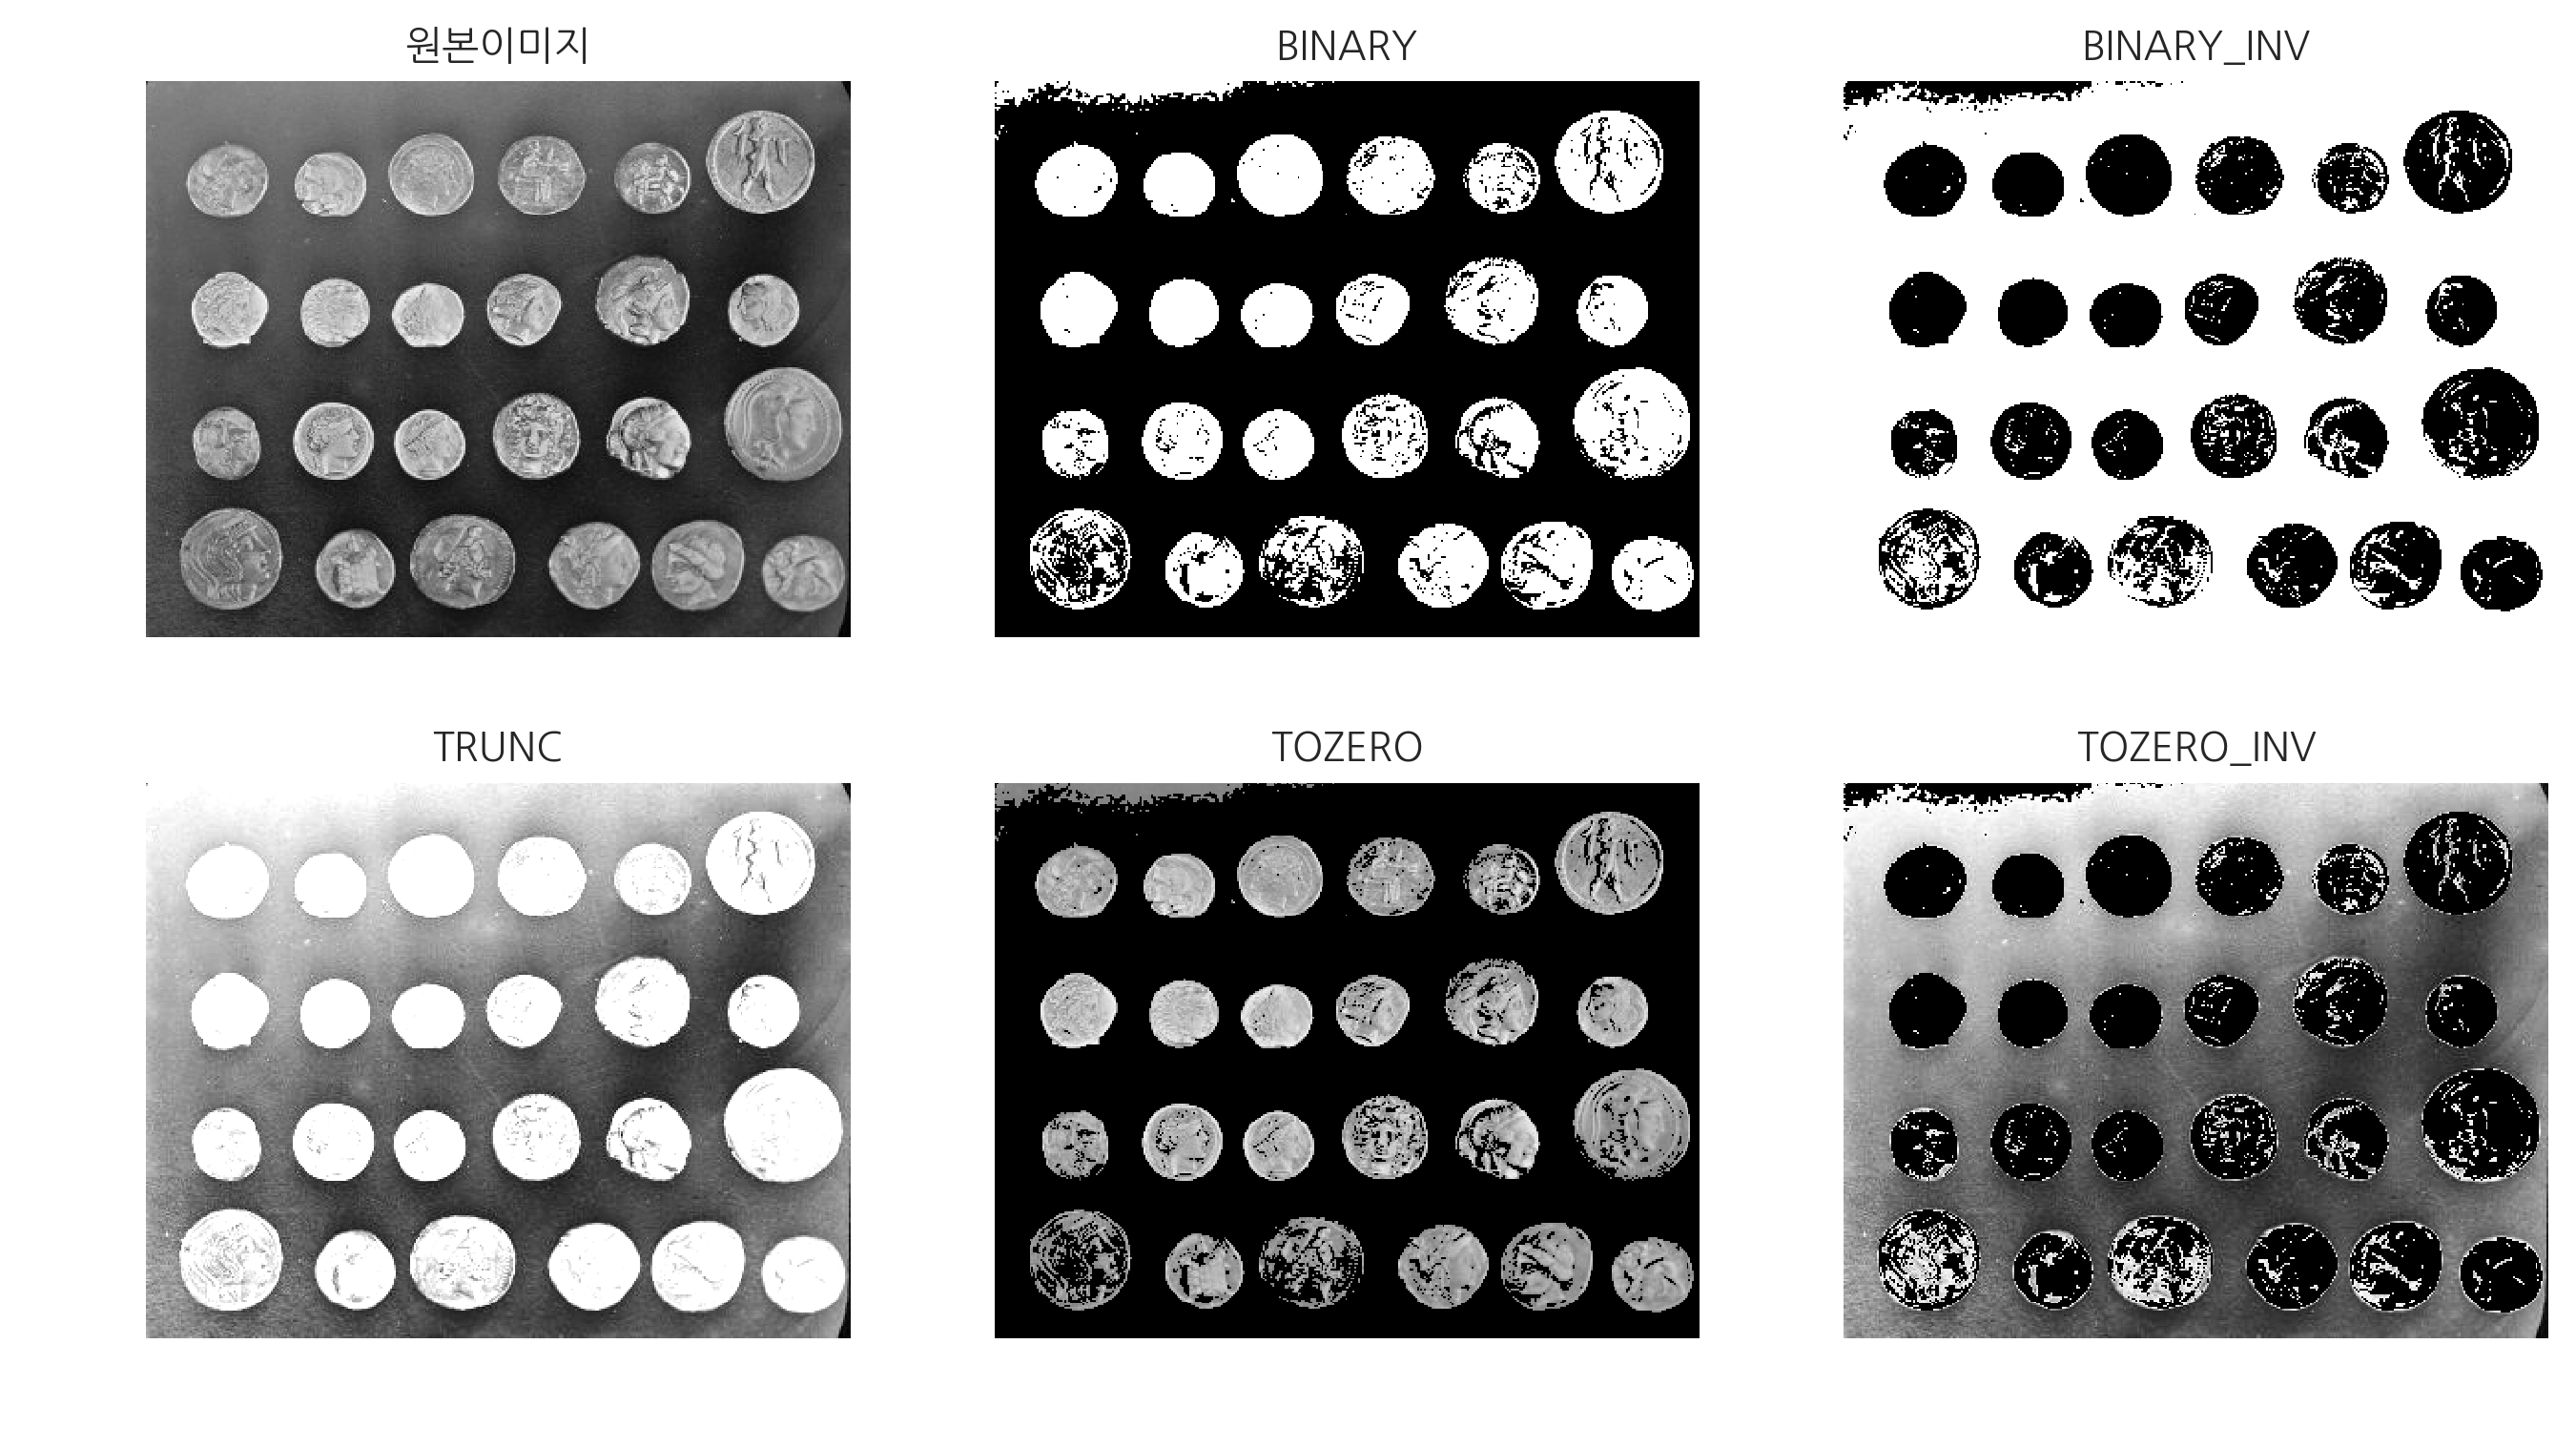

In [1]:
import cv2
from skimage.data import coins

img = coins()

maxval = 255
thresh = maxval / 2

_, thresh1 = cv2.threshold(img, thresh, maxval, cv2.THRESH_BINARY)
_, thresh2 = cv2.threshold(img, thresh, maxval, cv2.THRESH_BINARY_INV)
_, thresh3 = cv2.threshold(img, thresh, maxval, cv2.THRESH_TRUNC)
_, thresh4 = cv2.threshold(img, thresh, maxval, cv2.THRESH_TOZERO)
_, thresh5 = cv2.threshold(img, thresh, maxval, cv2.THRESH_TOZERO_INV)

titles = ['원본이미지', 'BINARY', 'BINARY_INV', 'TRUNC', 'TOZERO', 'TOZERO_INV']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]

plt.figure(figsize=(9, 5))
for i in range(6):
    plt.subplot(2, 3, i+1), plt.imshow(images[i], 'gray')
    plt.title(titles[i], fontdict={'fontsize': 10})
    plt.axis('off')

plt.tight_layout(pad=0.7)
plt.show()

## 적응임계처리

임계처리의 경우는 이미지 전체에 하나의 기준값을 적용한다. 적응임계처리는 일정한 영역 내의 이웃한 픽셀들의 값들을 이용하여 해당 영역에 적용할 기준값을 자체적으로 계산한다. OpenCV에서는 `adaptiveThreshold` 함수로 구현되어 있다. 

* `adaptiveThreshold(src, maxValue, adaptiveMethod, thresholdType, blockSize, C)` 
  * `src` : 그레이스케일 이미지
  * `maxValue` – 기준값을 넘었을 때 적용할 값
  * `adaptiveMethod` : 영역 내에서 기준값을 계산하는 방법. 
    * `ADAPTIVE_THRESH_MEAN_C`: 영역 내의 평균값에 C를 뺀 값을 기준값으로 사용
    * `ADAPTIVE_THRESH_GAUSSIAN_C`: 영역에 추후 설명할 가우시안 블러를 적용한 후 C를 뺀 값을 기준값으로 사용
  * `thresholdType` : 임계처리 유형
    * `THRESH_BINARY`
    * `THRESH_BINARY_INV`
  * `blockSize` : 임계처리를 적용할 영역의 크기
  * `C` : 평균이나 가중평균에서 차감할 값


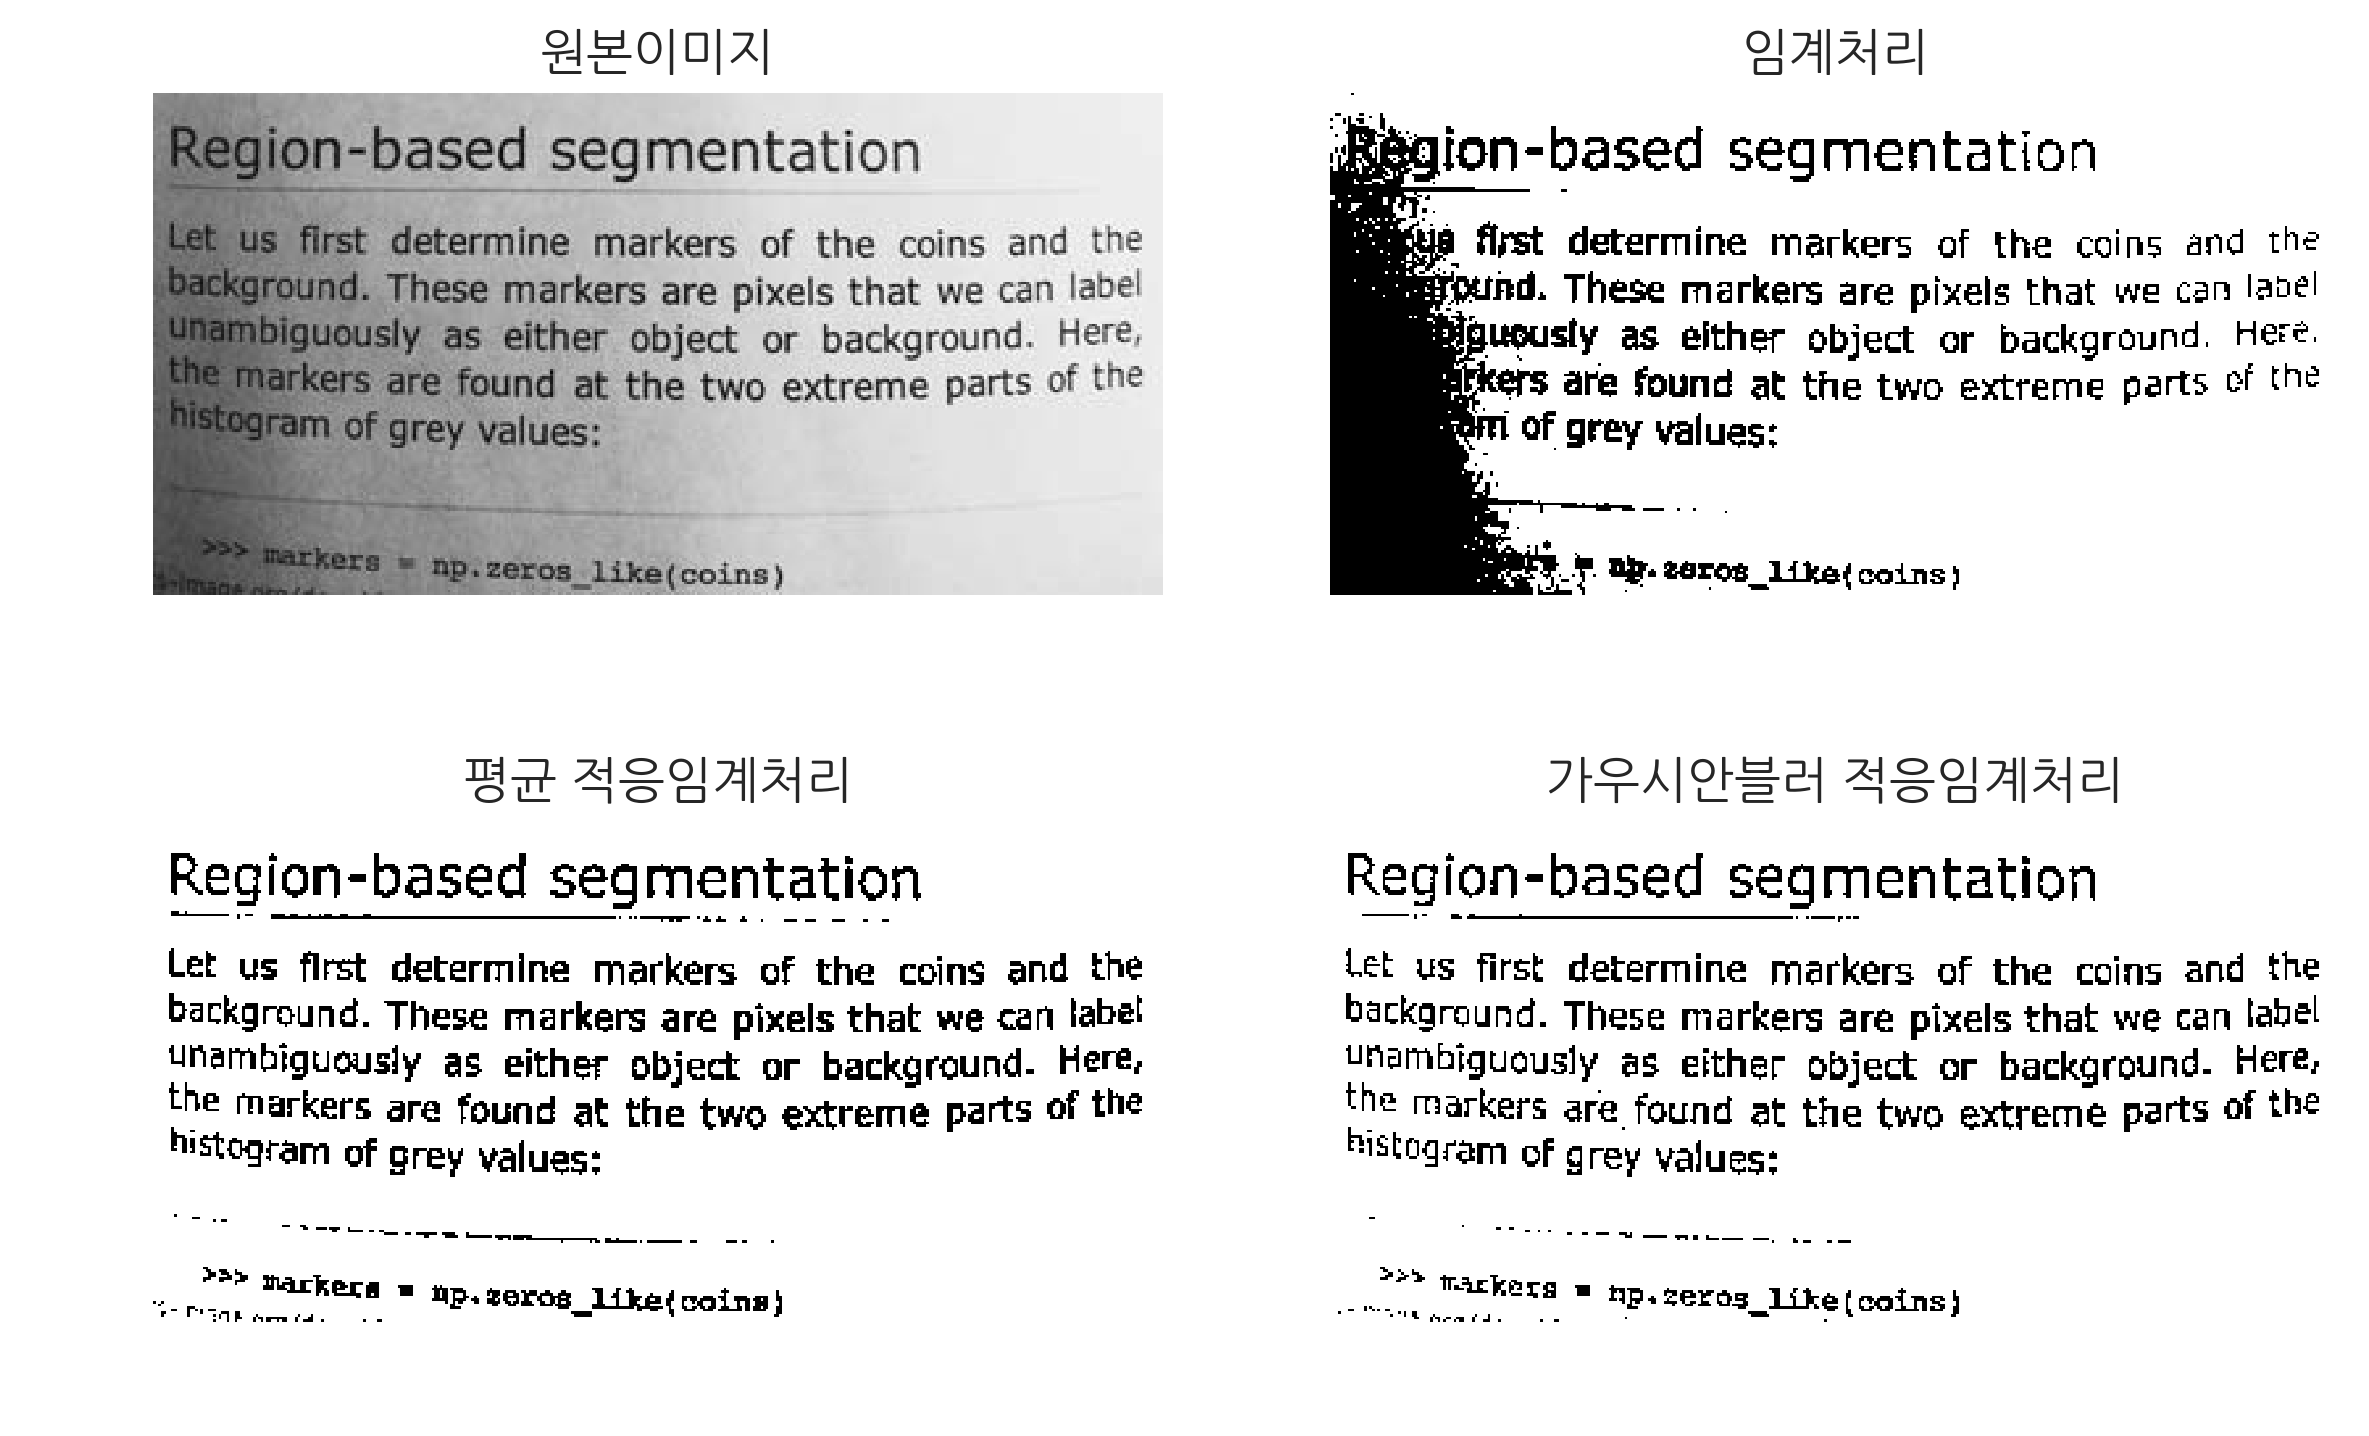

In [2]:
from skimage.data import page

img = page()

maxval = 255
thresh = 126
ret, th1 = cv2.threshold(img, thresh, maxval, cv2.THRESH_BINARY)

k = 15
C = 20

th2 = cv2.adaptiveThreshold(
    img, maxval, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, k, C)
th3 = cv2.adaptiveThreshold(
    img, maxval, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, k, C)

images = [img, th1, th2, th3]
titles = ['원본이미지', '임계처리', '평균 적응임계처리', '가우시안블러 적응임계처리']

plt.figure(figsize=(8, 5))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i], 'gray')
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

## 이미지 필터링

이미지 필터링(image filtering)은 필터(filter) 또는 커널(kernel) 또는 윈도우(window)라고 하는 정방행렬을 정의하고 이 커널을 이동시키면서 같은 이미지 영역과 곱하여 그 결과값을 이미지의 해당 위치의 값으로 하는 새로운 이미지를 만드는 연산이다. 기호 $\otimes$로 표기한다.

원본 이미지의 $(x,y)$ 위치의 명도를 $f(x,y)$, 필터 이미지를 $h(x,y)$, 필터링된 결과를 $g(x,y)$라고 하면 수식으로 다음과 같다.

$$ f \otimes h = \sum_{u=-K/2}^{K} \sum_{v=-K/2}^{K} f(x + u, y + v) \cdot h(u, v) $$

이 식에서 $K$는 필터 크기의 절반을 뜻한다. 예를 들어 $3\times 3$ 크기의 필터에서는 $K=1$이다. 위 식을 줄여서 다음처럼 나타내기도 한다. $W$S는 윈도우 영역을 뜻한다.

$$ f \otimes h = \sum_{W} f(x + u, y + v) \cdot h(u, v) $$

위 식에서 필터를 좌우 상하로 뒤집으면 콘볼루션(convolution)이라고 한다. 기호 $*$로 표기한다.


$$ f * h = f \otimes \tilde{h} = \sum_{W} f(x - u, y - v) \cdot \tilde{h}(u, v) $$

$$ \tilde{h}(u, v) = h(-u, -v) $$

<img src="https://datascienceschool.net/upfiles/0742fffa9e614cd78a8cba4ad08f0bc7.jpeg" width="100%">

그림 38.2 : 윈도우 연산

openCV에서는 `filter2D` 함수를 사용한다


`filter2D(src, ddepth, kernel[, dst[, anchor[, delta[, borderType]]]])`

* `src`: 이미지
* `ddepth`: 이미지 깊이(자료형 크기). -1이면 입력과 동일
* `kernel`: 커널 행렬


다음 코드는 평균을 구하는 커널 적용한 예다. 커널 크기가 커지면서 이미지가 점점 더 흐려지는 것을 볼 수 있다. 

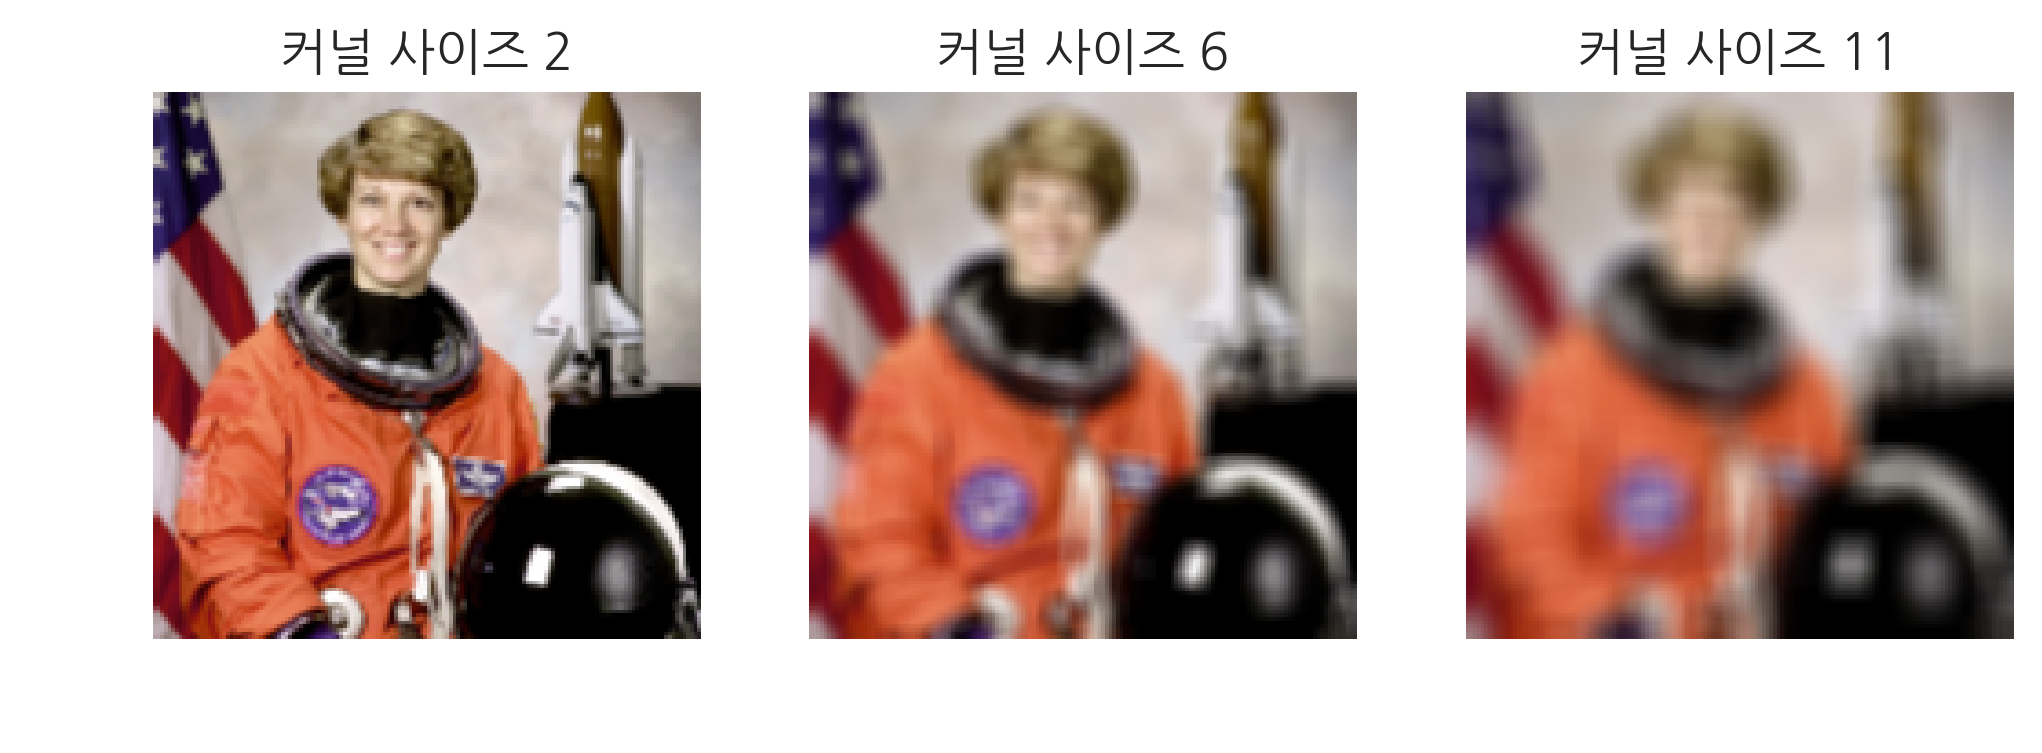

In [3]:
import cv2
from skimage.data import astronaut

img = astronaut()
img = cv2.resize(img, dsize=(150, 150))

plt.figure(figsize=(8, 3))
for i, k in enumerate([2, 6, 11]):
    kernel = np.ones((k, k)) / k**2
    filtering = cv2.filter2D(img, -1, kernel)
    plt.subplot(1, 3, i + 1)
    plt.imshow(filtering)
    plt.title("커널 사이즈 {}".format(k))
    plt.axis("off")

plt.show()

## 블러

블러는 이미지 필터링을 사용하여 이미지를 흐리게 만드는 것을 말한다. 노이즈를 제거하거나 경계선을 흐리게 하기 위해 쓴다. 다음과 같은 방법이 있다.

* 평균 블러
* 중앙값 블러
* 가우시안 블러
* 양방향 블러

### 평균 블러

평균 블러 방법은 균일한 값을 가지는 커널을 이용한 이미지 필터링이다. 따라서 커널 영역내의 평균값으로 해당 픽셀을 대체한다. OpenCV에서는 `blur` 함수로 구현되어 있다.

`blur(src, ksize)`

* `src`: 원본 이미지
* `ksize`: 커널 크기

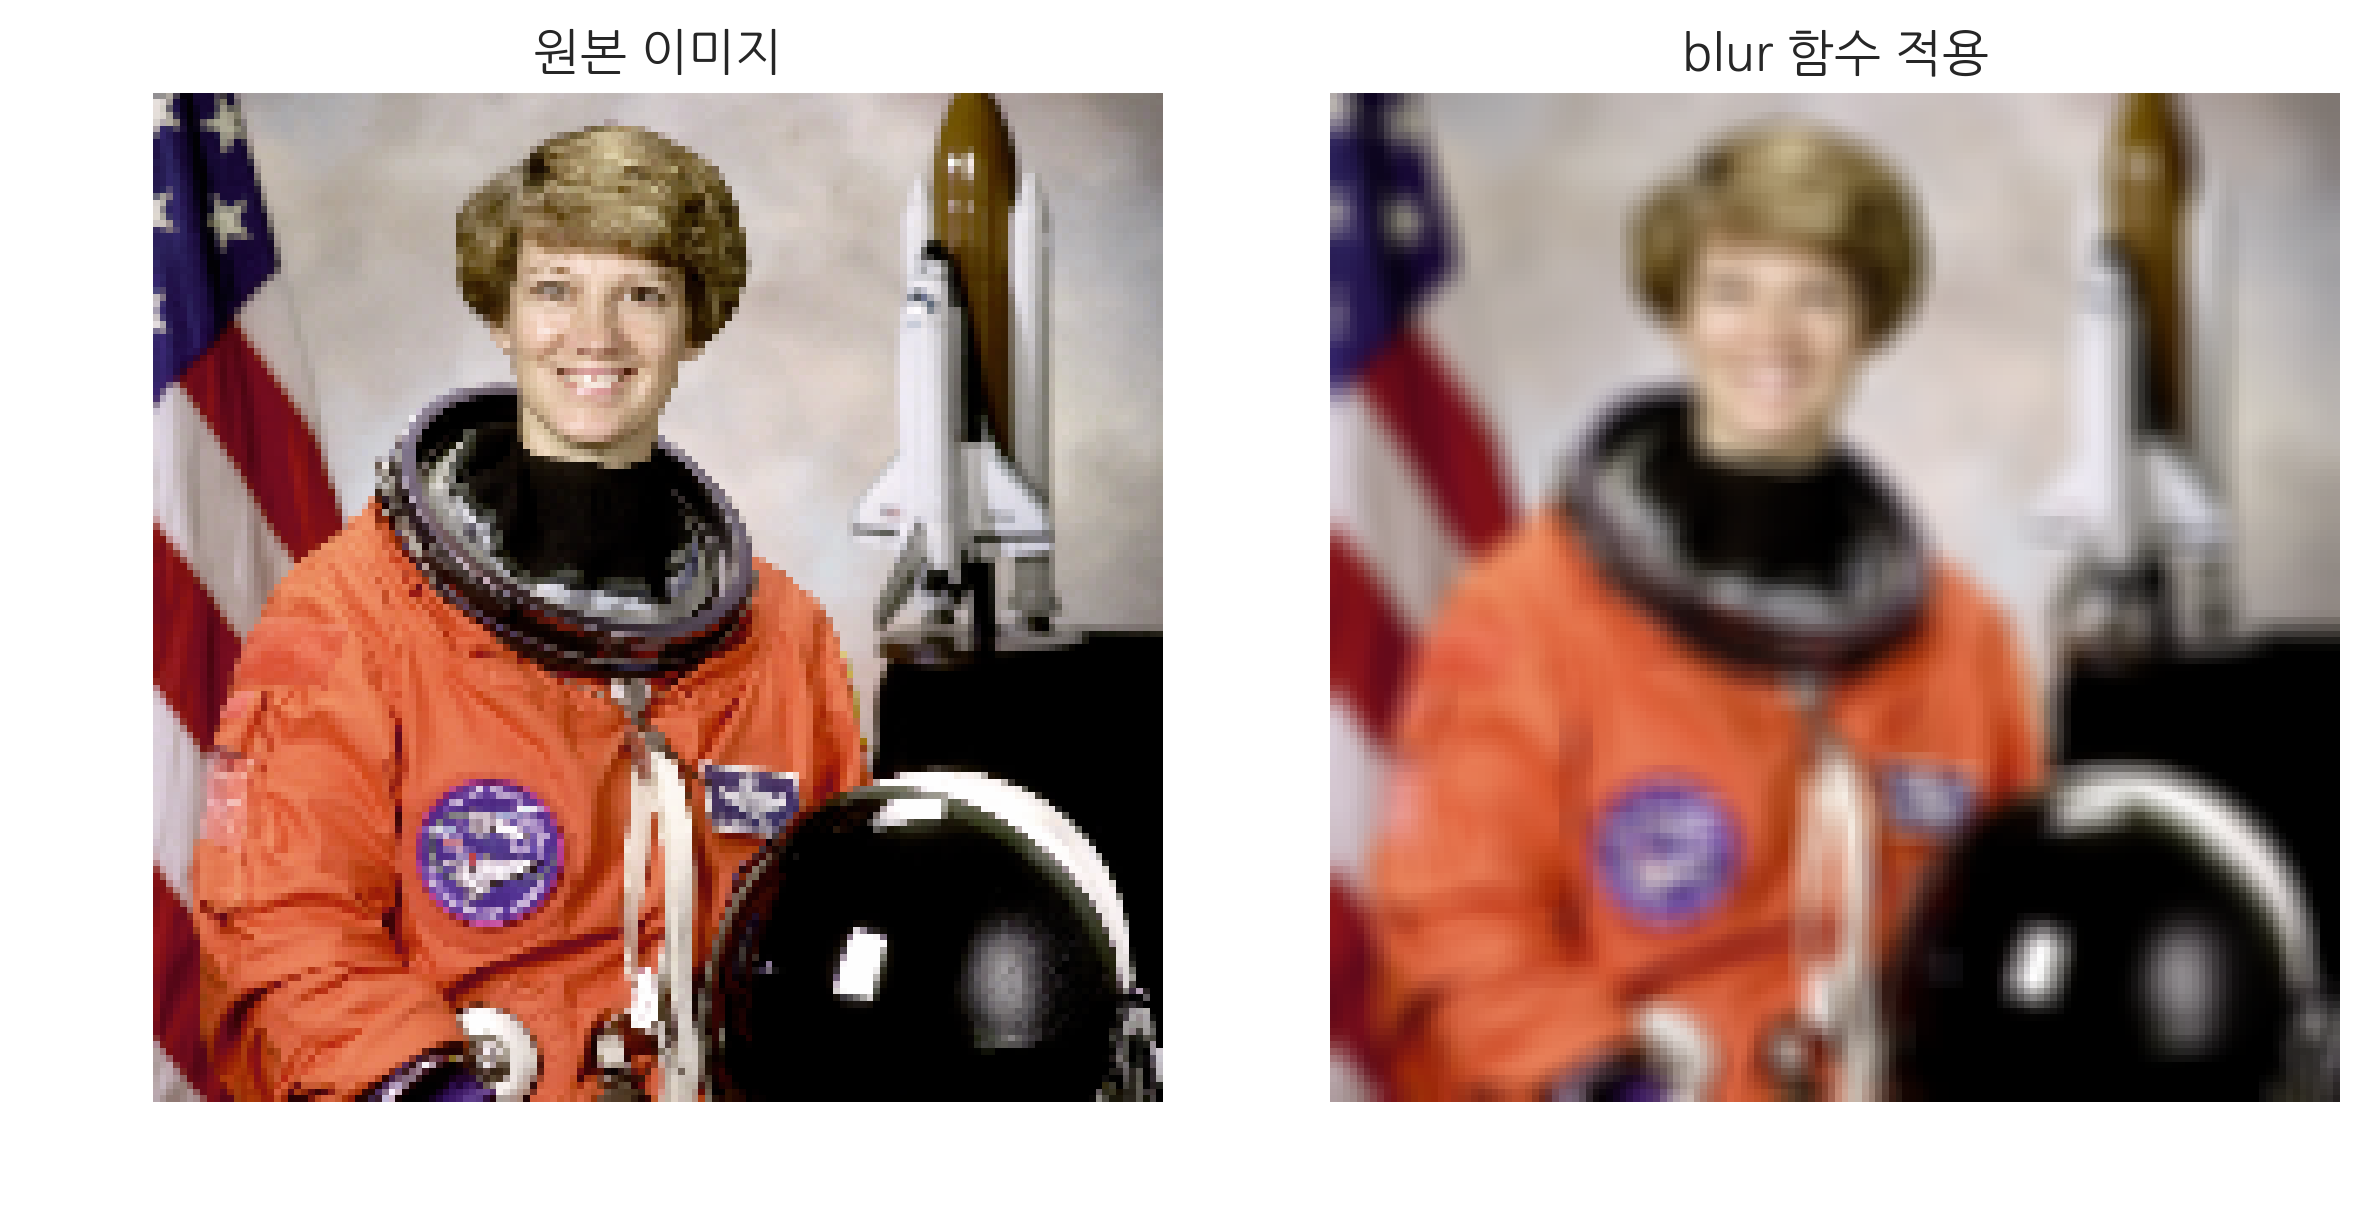

In [4]:
blur = cv2.blur(img, (5, 5))
boxfilter = cv2.boxFilter(img, -1, (5, 5))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("원본 이미지")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(blur)
plt.title("blur 함수 적용")
plt.axis('off')

plt.tight_layout()
plt.show()

### 중앙값 블러 

중앙값 블러는 평균이 아닌 중앙값으로 해당 픽셀을 대체한다. 이 필터링 방법은 점 모양의 잡음을 제거하는데 효과적이다. OpenCV에서는 `medianBlur` 함수를 사용한다.

`medianBlur(src, ksize)`

* `src`: 원본 이미지
* `ksize`: 커널 크기

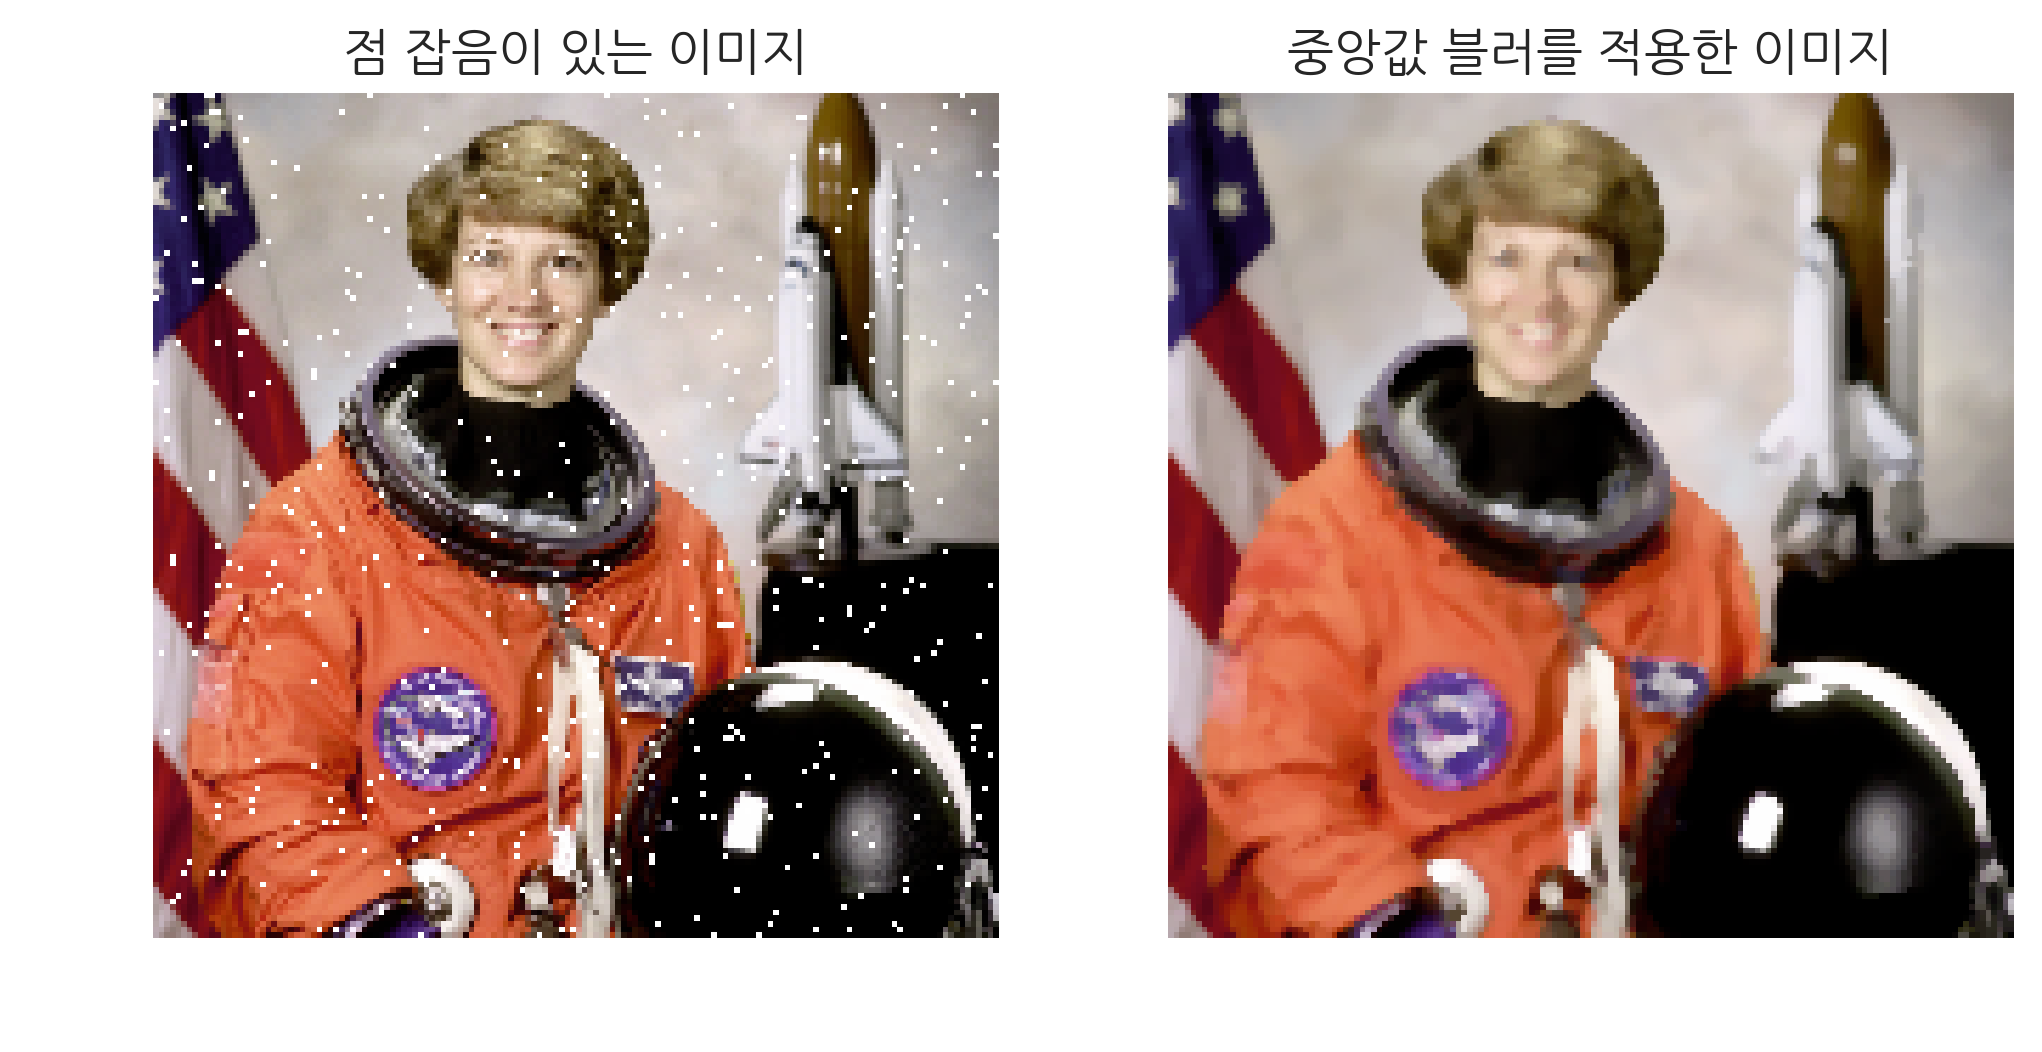

In [5]:

# 점 잡음 적용
img_noise = img.copy()

np.random.seed(0)
N = 500
idx1 = np.random.randint(img.shape[0], size=N)
idx2 = np.random.randint(img.shape[1], size=N)
img_noise[idx1, idx2] = 255

# 중앙값 블러로 잡음 제거
img_denoise = cv2.medianBlur(img_noise, 3)

plt.subplot(1, 2, 1)
plt.imshow(img_noise)
plt.title("점 잡음이 있는 이미지")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_denoise)
plt.title("중앙값 블러를 적용한 이미지")
plt.axis('off')
plt.show()

### 가우시안 블러

가우시안 블러는  가우시안 함수 $G$를 커널로 사용한다. 가우시안 커널은 중앙 위치 $(x,y)$와 커널 위치 $(x+u, y+v)$의 거리 차이 $(u,v)$가 클수록 가중치가 작아진다. 

$$ f \otimes G = \sum_{W} f(x + u, y + v) \cdot G(u, v) = \sum_{W} f(x + u, y + v) \cdot G((x+u)-x, (y+v)-y) $$


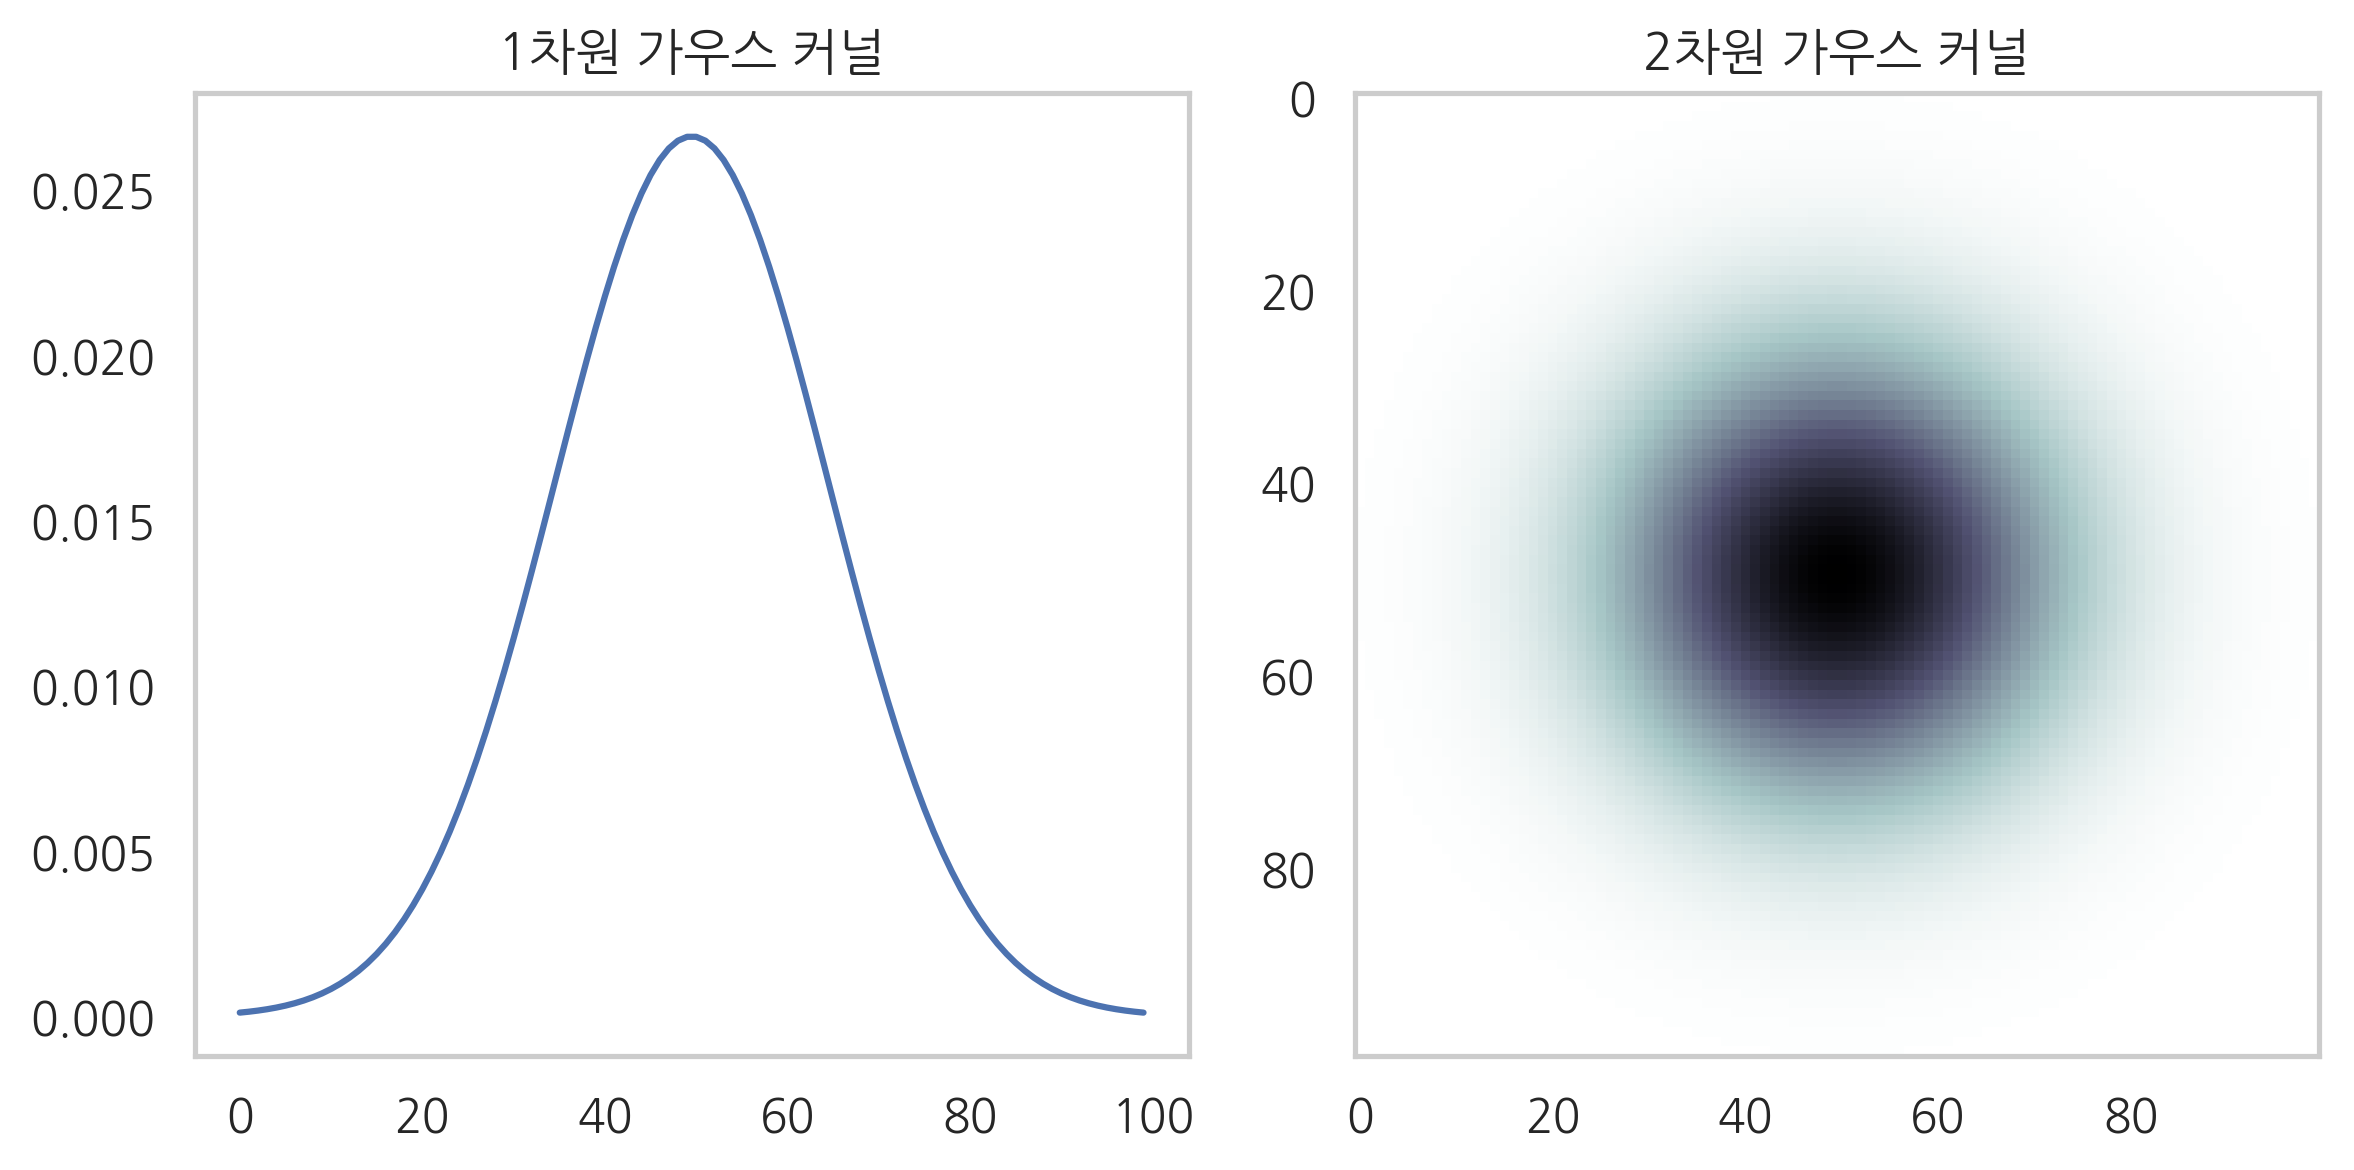

In [6]:
gauss1d = cv2.getGaussianKernel(100, 15)
gauss2d = gauss1d @ gauss1d.T

plt.figure(figsize=(8, 4))

plt.subplot(121)
plt.plot(gauss1d)
plt.grid(False)
plt.title("1차원 가우스 커널")

plt.subplot(122)
plt.imshow(gauss2d, cmap=mpl.cm.bone_r)
plt.grid(False)
plt.title("2차원 가우스 커널")

plt.tight_layout()
plt.show()

OpenCV에서는 `GaussianBlur` 함수로 구현되어 있다.

`GaussianBlur(src, ksize, sigmaX)`

* `src`: 원본 이미지
* `ksize`: 커널 크기
* `sigmaX`: 표준편차


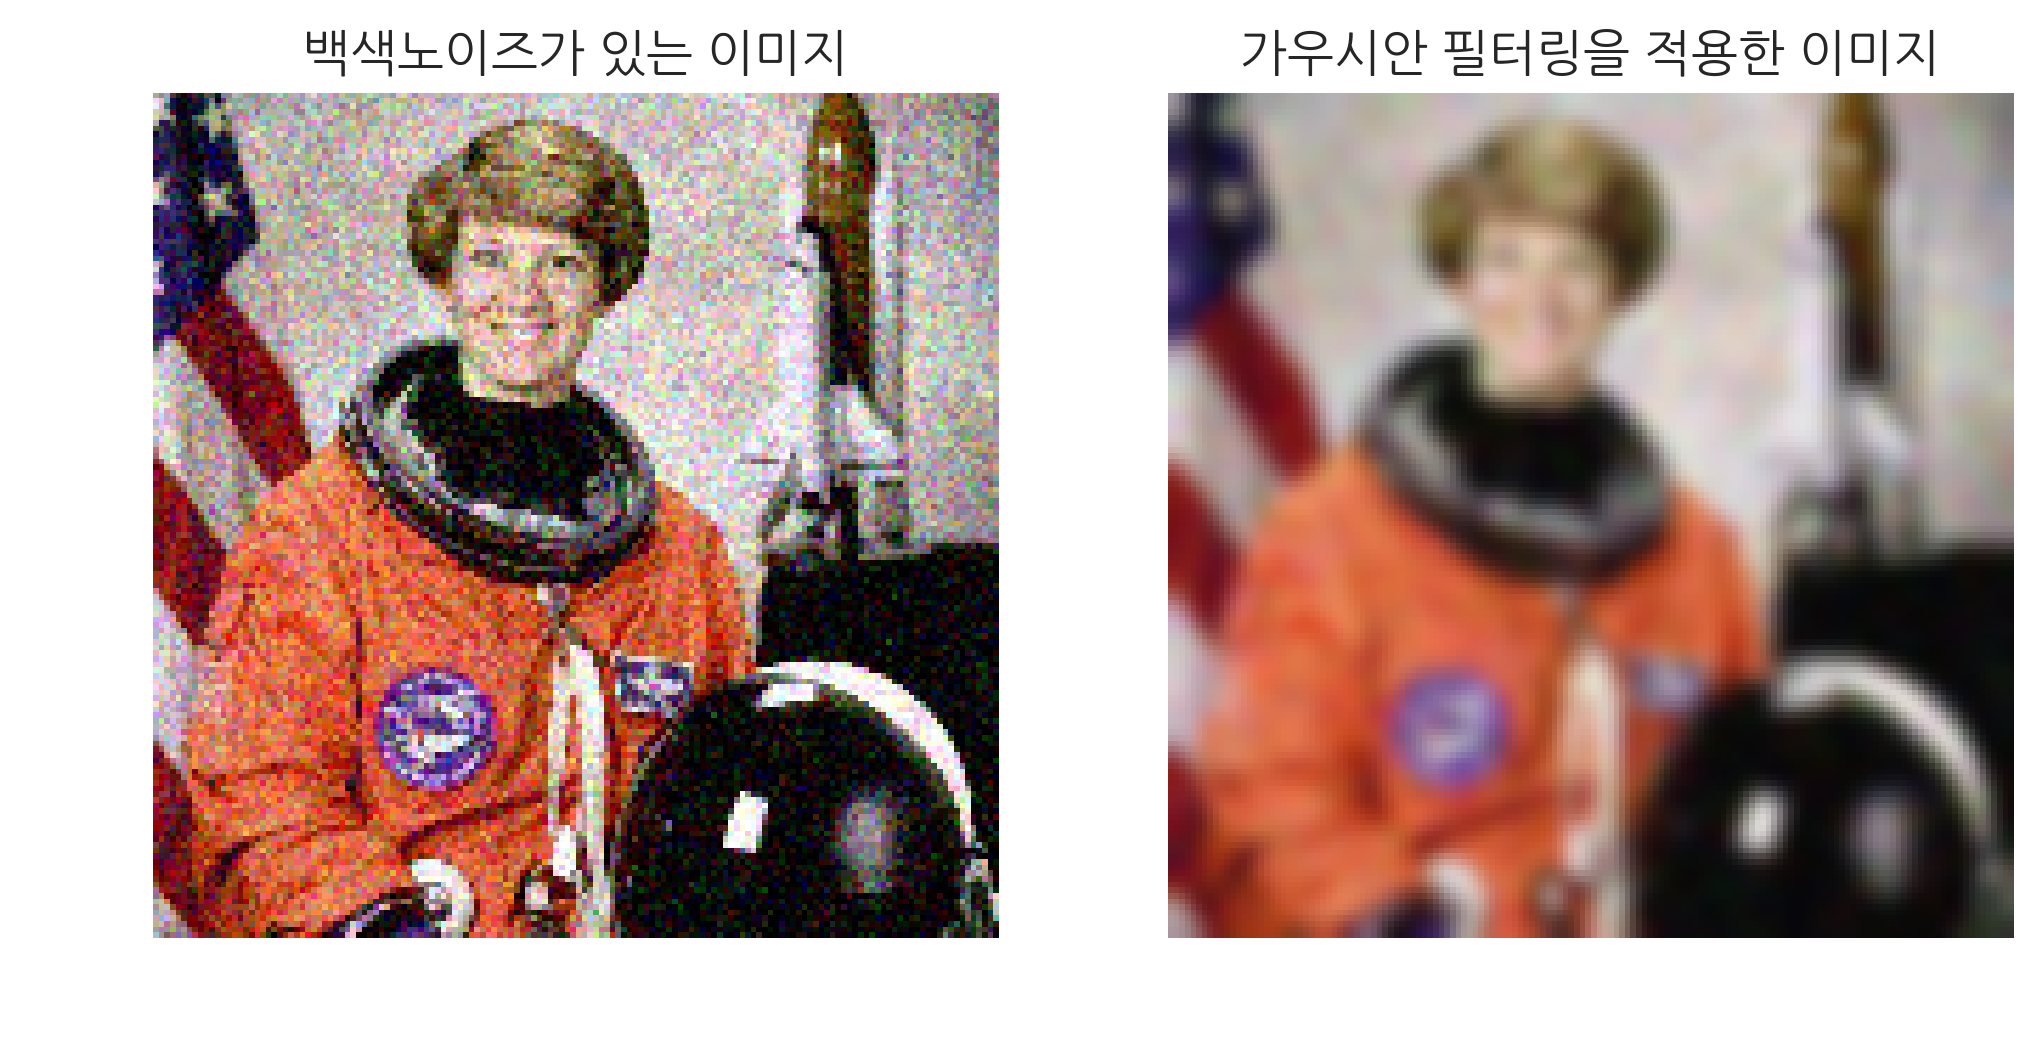

In [7]:
# 백색 잡음
img_noise = np.clip((img / 255 + np.random.normal(scale=0.1, size=img.shape)) * 255, 0, 255).astype('uint8')

# 가우시안 블러로 잡음 제거
img_denoise = cv2.GaussianBlur(img_noise, (9, 9), 2)

plt.subplot(1, 2, 1)
plt.imshow(img_noise)
plt.title("백색노이즈가 있는 이미지")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_denoise)
plt.title("가우시안 필터링을 적용한 이미지")
plt.axis('off')

plt.show()

### 양방향 필터링

가우시안 필터링을 쓰면 이미지의 경계선도 흐려진다. 양방향 필터링(Bilateral Filtering)은 두 픽셀과의 거리 뿐 아니라 두 픽셀의 명암값의 차이도 커널에 넣어서 가중치로 곱한다. 

* 일반 이미지 필터링

$$ f \otimes G = \sum_{W} f(x + u, y + v) \cdot G((x+u)-x, (y+v)-y) $$

* 양방향 이미지 필터링

$$ f \otimes G = \sum_{W} f(x + u, y + v) \cdot G((x+u)-x, (y+v)-y) \cdot G'(f(x+u)-f(x), f(y+v)-f(y)) $$


따라서 픽셀값의 차이가 너무 크면 가중치가 0에 가까운 값이 되어 합쳐지지 않으므로 영역과 영역사이의 경계선이 잘 보존된다.

OpenCV에서는 `bilateralFilter` 함수로 구현되어 있다.


`bilateralFilter(src, d, sigmaColor, sigmaSpace)`

* `src`: 원본 이미지
* `d`: 커널 크기
* `sigmaColor`: 색공간 표준편차. 값이 크면 색이 많이 달라도 픽셀들이 서로 영향을 미친다.
* `sigmaSpace`: 거리공간 표준편차. 값이 크면 멀리 떨어져있는 픽셀들이 서로 영향을 미친다.

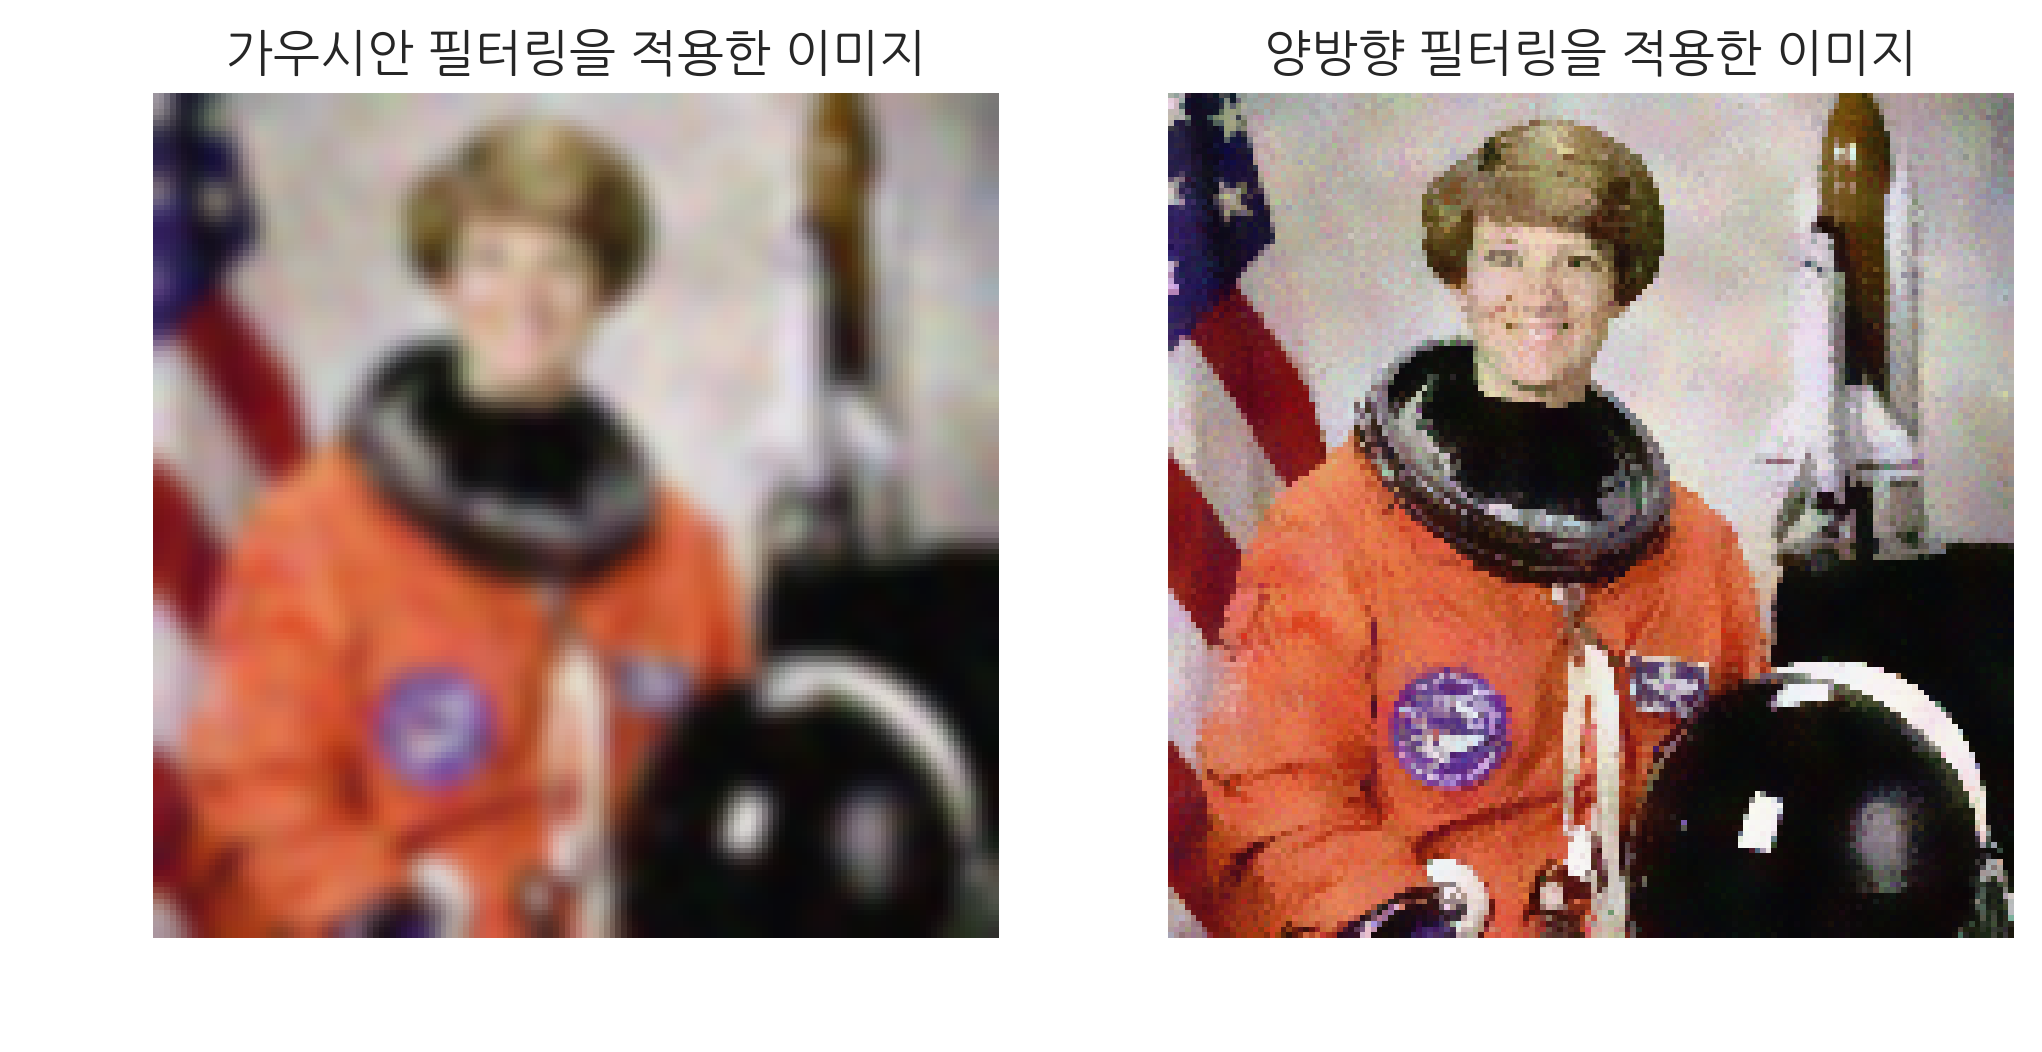

In [8]:
img_denoise1 = cv2.GaussianBlur(img_noise, (9, 9), 2)
img_denoise2 = cv2.bilateralFilter(img_noise, 9, 75, 75)

plt.subplot(1, 2, 1)
plt.imshow(img_denoise1)
plt.title("가우시안 필터링을 적용한 이미지")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_denoise2)
plt.title("양방향 필터링을 적용한 이미지")
plt.axis('off')

plt.show()

## 형태학적 변환 

이진화한 이미지에서는 같은 값을 가진 픽셀이 이웃하여 있으면 이를 형태학적 영역(morphological region)으로 생각할 수 있다.
이미지의 형태학적 변환(morphological transformation)은 이미지 필터링을 사용하여 영역을 변화시키는 방법이다.

변환에 적용할 커널은 `getStructuringElement` 함수로 생성한다. 

`getStructuringElement(shape, ksize)`

* `shape`: 커널 모양
  * `cv2.MORPH_RECT`: 사각형 
  * `cv2.MORPH_ELLIPSE`: 타원형 
  * `cv2.TMORPH_CROSS`: 십자
* `ksize`: 커널 크기

In [9]:
cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

array([[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]], dtype=uint8)

In [10]:
cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

array([[0, 0, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 1, 0, 0]], dtype=uint8)

In [11]:
cv2.getStructuringElement(cv2.MORPH_CROSS, (5, 5))

array([[0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0]], dtype=uint8)

### 침식 기법

침식 기법은 각 픽셀에 커널을 적용하여 커널 영역 내의 최솟값으로 해당 픽셀을 대체한다. 이진화된 이미지에서는 0인 영역이 증가한다. 

OpenCV에서는 `erode`함수로 구현되어 있다. 

`erode(src, kernel)`

* `src`: 원본 이미지
* `kernel`: 커널


다음 코드는 이미지를 여러 커널 모양을 이용하여 침식 기법으로 변환한다. 검은색이 0인 영역, 흰색이 1인 영역이다. 검은색(0)이 흰색을 침식해 들어가는 것을 알 수 있다.

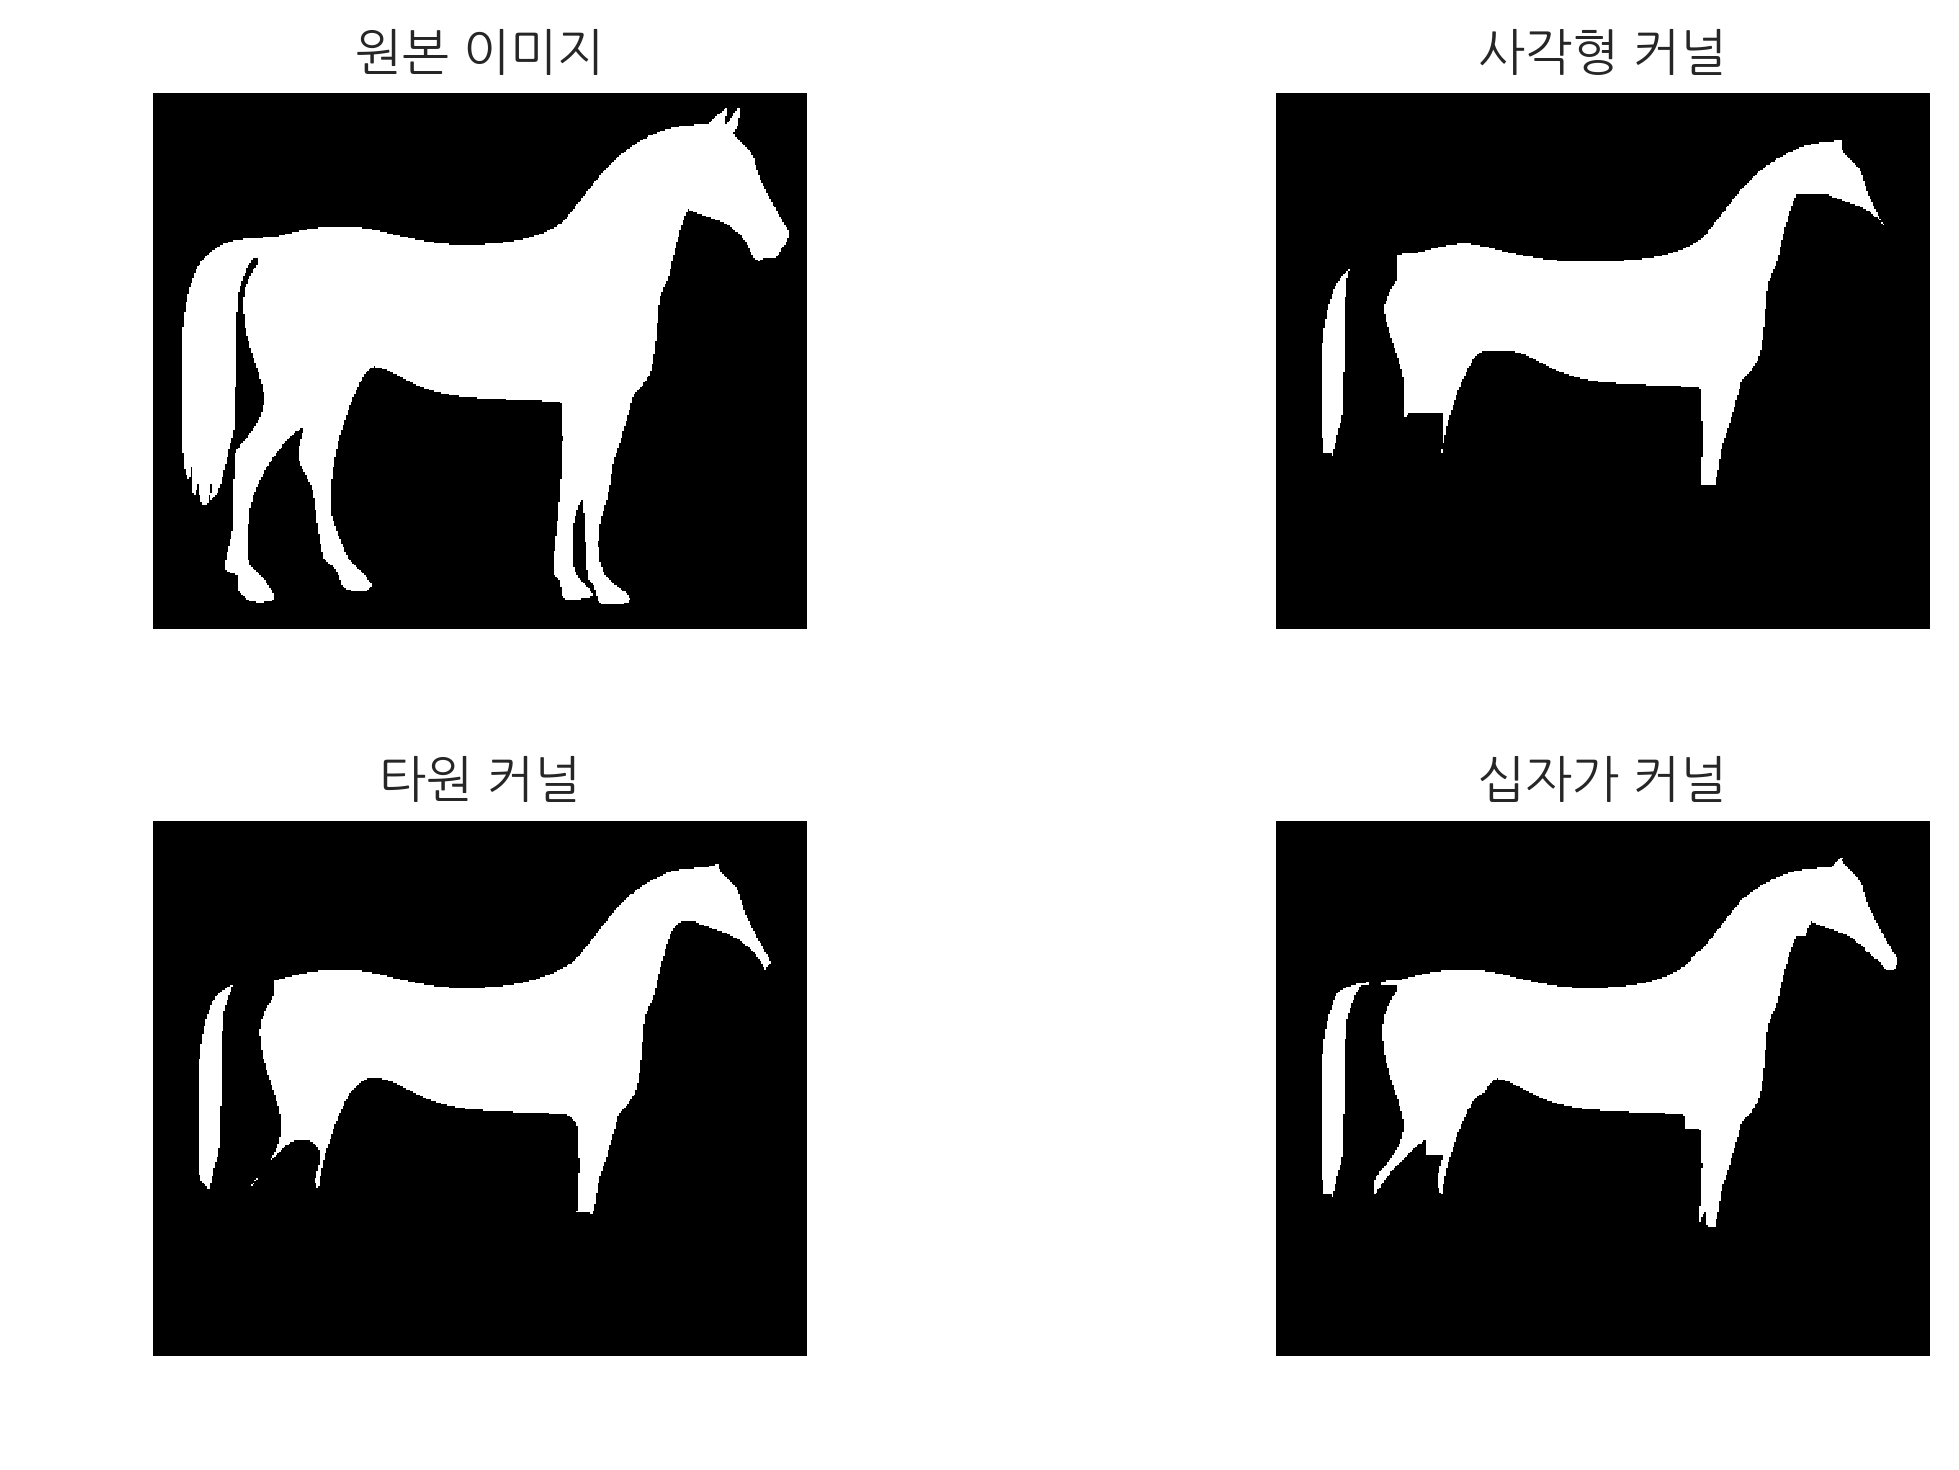

In [12]:
from skimage.data import horse

img = horse().astype('uint8')
img = np.ones(img.shape) - img

ksize = (20, 20)
kernel = {}
kernel[0] = cv2.getStructuringElement(cv2.MORPH_RECT, ksize)
kernel[1] = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, ksize)
kernel[2] = cv2.getStructuringElement(cv2.MORPH_CROSS, ksize)
title = ["사각형 커널", "타원 커널", "십자가 커널"]

plt.subplot(2, 2, 1)
plt.imshow(img, cmap="gray")
plt.title("원본 이미지")
plt.axis('off')
for i in range(3):
    erosion = cv2.erode(img, kernel[i])
    plt.subplot(2, 2, i+2)
    plt.imshow(erosion, cmap='bone')
    plt.title(title[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

### 팽창

팽창(Dilation)은 침식과 반대로 커널 영역내의 최댓값으로 해당 픽셀을 대체하는 것이다. OpenCV에서는  `dilate` 함수로 구현되어 있다.


`dilate(src, kernel)`

* `src`: 원본 이미지
* `kernel`: 커널


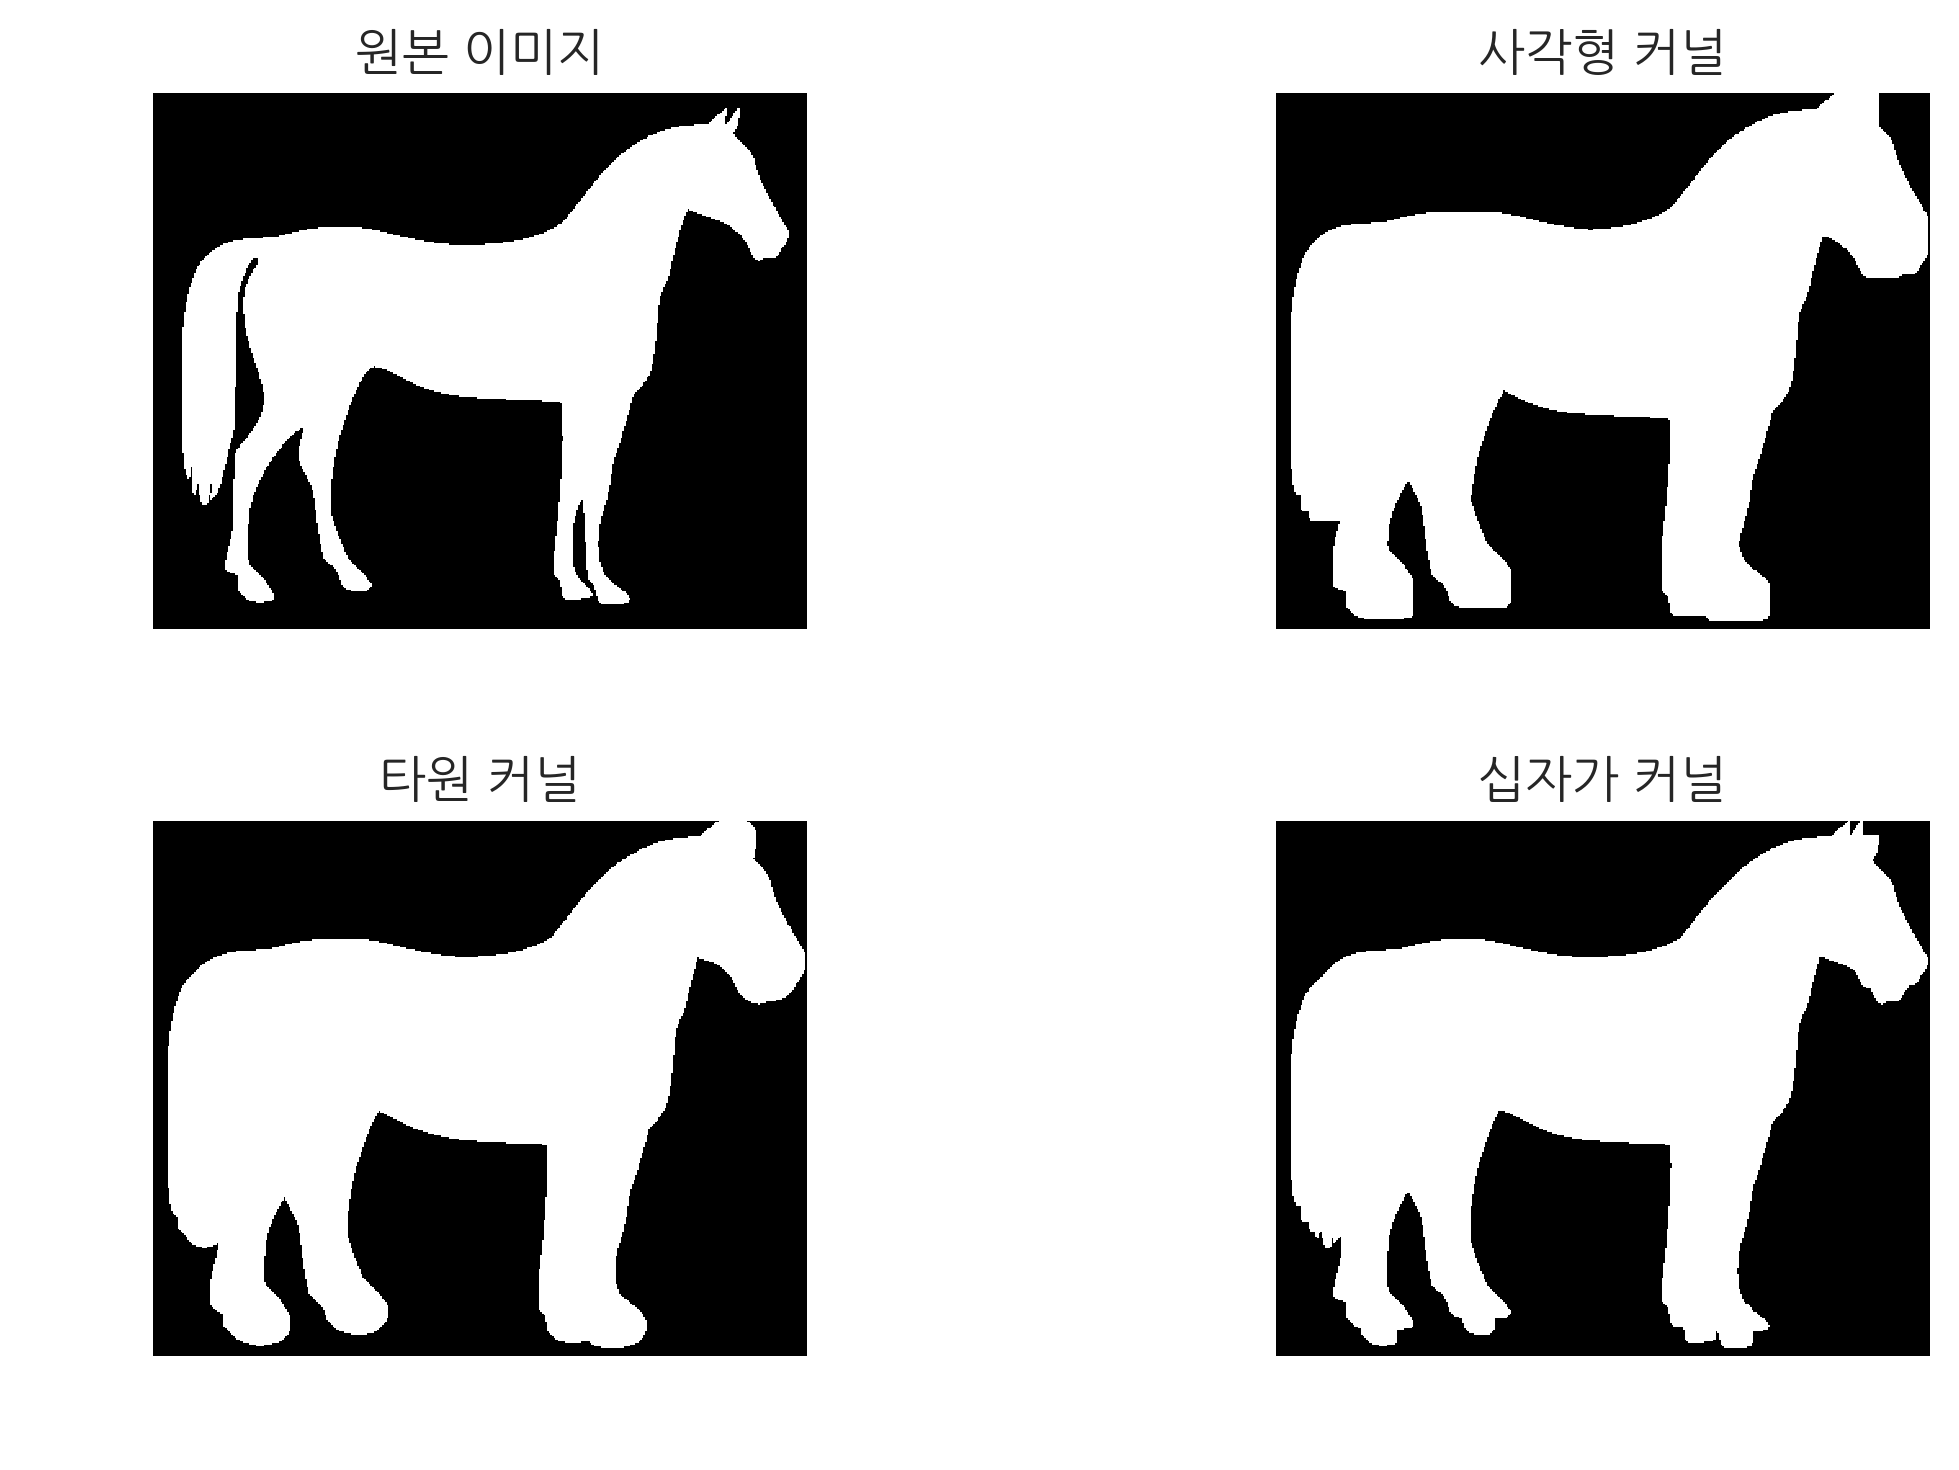

In [13]:
plt.subplot(2, 2, 1)
plt.imshow(img, cmap="gray")
plt.title("원본 이미지")
plt.axis('off')
for i in range(3):
    erosion = cv2.dilate(img, kernel[i])
    plt.subplot(2, 2, i+2)
    plt.imshow(erosion, cmap='bone')
    plt.title(title[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

### 그레디언트, 오프닝, 클로징

그레디언트는 팽창으로 확장시킨 영역에서 침식으로 축소시킨 영역을 빼서 윤곽선을 파악하는 것이다. 

이와 유사한 기법으로 오프닝(Opening)과 클로징(Closing)이 있다. 오프닝은 침식을 적용한 뒤 팽창을 적용하는 것으로 영역이 점점 둥글게 되므로 점 잡음, 작은 물체, 돌기 등을 제거하는데 적합하다. 클로징은 반대로 팽창을 적용한 뒤 침식을 적용하여 영역이 영역이 붙기 때문에 전체적인 윤곽을 파악하는데 적합하다.

그레디언트를 구하려면 OpenCV의 `morphologyEx` 라는 함수를 사용한다. 

`morphologyEx(src, op, kernel)`

* `src`: 원본 이미지
* `op`: 
  * `cv2.MORPH_OPEN`: `cv2.dilate(cv2.erode(image))`
  * `cv2.MORPH_CLOSE`: `cv2.erode(cv2.dilate(image))`
  * `cv2.MORPH_GRADIENT`: `cv2.dilate(image) - cv2.erode(image)`
  * `cv2.MORPH_TOPHAT`: `image - opening(image)`
  * `cv2.MORPH_BLACKHAT`: `image - closing(image)`
* `kernel`: 커널


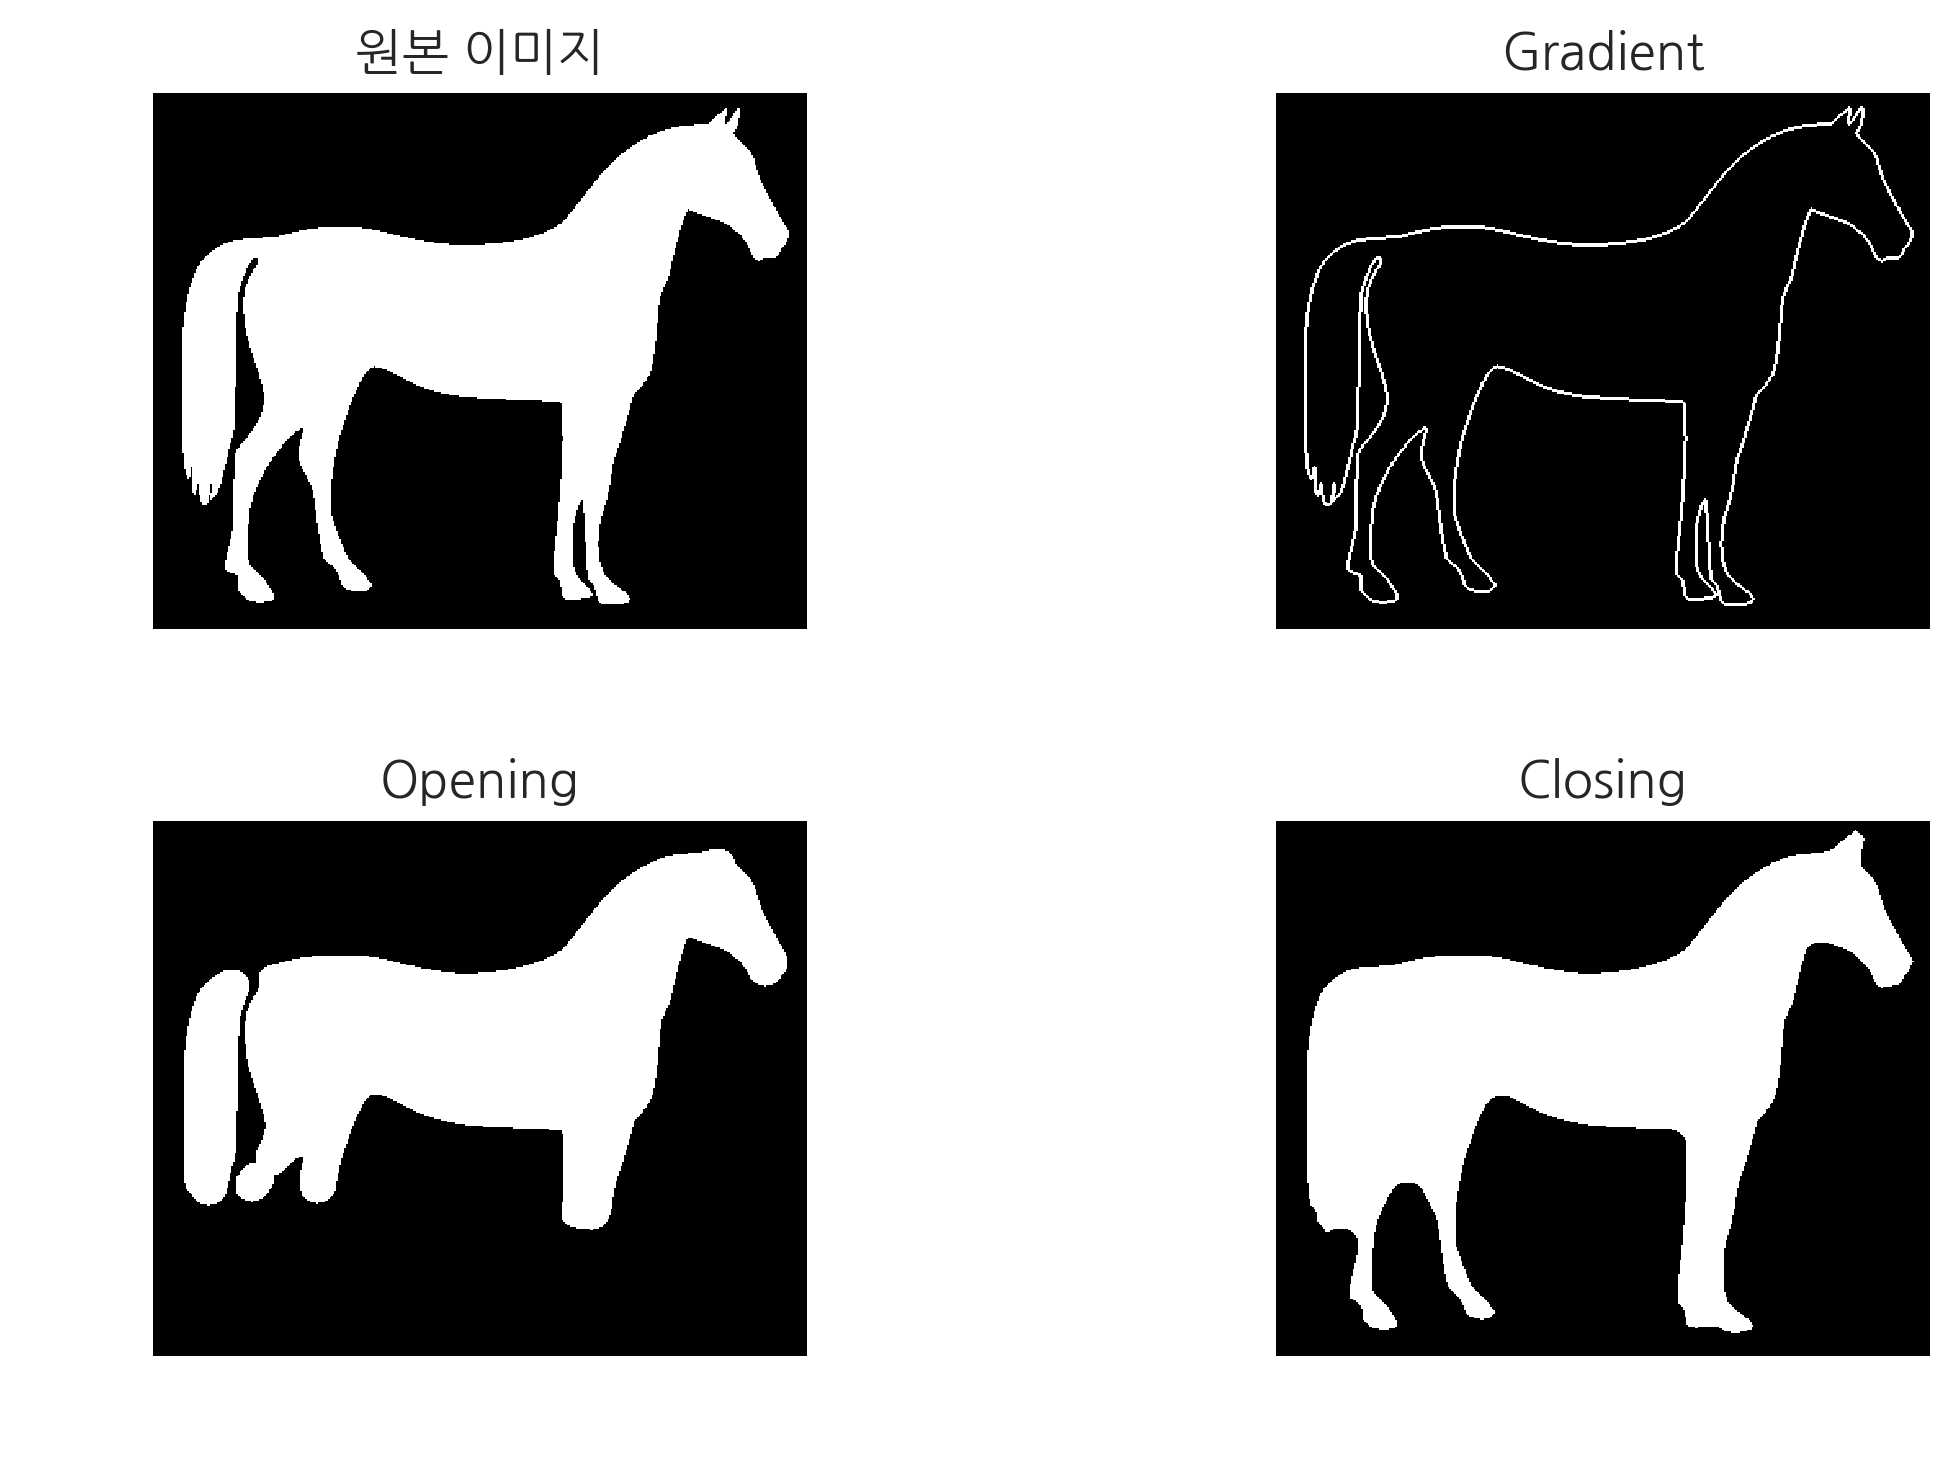

In [14]:
opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, 
    cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20, 20))
)

closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, 
    cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (20, 20))
)

gradient = cv2.morphologyEx(img, cv2.MORPH_GRADIENT, 
    cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
)

images = [img, gradient, opening, closing]
titles = ["원본 이미지", 'Gradient', 'Opening', 'Closing']

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

#### 연습 문제 1

다음 왼쪽 이미지를 필터링 처리하여 오른쪽 이미지와 같이 종이 부분만을 이진화하여라.
이미지는 다음 명령으로 내려받는다.

```
!wget https://datascienceschool.net/upfiles/63a2990218f1487b8e0dfd4dac8f3a5e.png -O receipt.png
```

<img src="https://datascienceschool.net/upfiles/bf701e2bc70141478cafe3c9b2b9f032.png">